import

In [1]:
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import os
import random
import os
print("XGBoost version:", xgboost.__version__)
print(xgboost.build_info())

#global variables
dir_path = "C:\\school\\SchoolProgram\\NTUST_CSIE_DS\\DataSet"
outputPath = 'XGBoost\\'
random_state = 42

XGBoost version: 3.1.1
{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [13, 0], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [3, 0, 3], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_NVCOMP': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'c:\\Users\\0978w\\.conda\\envs\\ntust_ds\\Library\\mingw-w64\\bin\\xgboost.dll'}


load data

In [2]:
df_preprocessing = pd.read_csv(os.path.join(dir_path, 'preprocessing_T1_2_3.csv'))

#auto drop non-numeric, nan columns
df_preprocessing = df_preprocessing.select_dtypes(include=[np.number]).dropna(axis=1)

df_test = pd.read_csv(os.path.join(dir_path, 'acct_predict.csv'))

print("Processed data shape:", df_preprocessing.shape)
print("Test data shape:", df_test.shape)

Processed data shape: (1795326, 30)
Test data shape: (4780, 2)


正歸化、split data

In [3]:
# 正規化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_preprocessing.copy().drop(columns=['label']))

# 分割資料集
y = df_preprocessing['label']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=random_state, stratify=y)

# 使用 SMOTE 進行過採樣
smote = SMOTE(random_state=random_state)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("SMOTE 後訓練集大小:", X_train.shape, "正類比例:", y_train.mean())
print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"訓練集中警示帳戶比例: {y_train.mean():.2%}")
print(f"測試集中警示帳戶比例: {y_test.mean():.2%}")

SMOTE 後訓練集大小: (2512050, 29) 正類比例: 0.5
訓練集大小: (2512050, 29)
測試集大小: (538598, 29)
訓練集中警示帳戶比例: 50.00%
測試集中警示帳戶比例: 0.06%


training XGBoost model

In [4]:
from sklearn.model_selection import GridSearchCV

# 定義參數網格
# param_grid = {
#     'n_estimators': [200, 400, 600],
#     'max_depth': [6, 8, 10],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # 初始化 XGBoost 分類器
# xgb_clf = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='roc_auc',
#     use_label_encoder=False,
#     random_state=random_state,
#     tree_method='gpu_hist'
# )

# print("開始訓練 XGBoost 模型...")
# # 使用 GridSearchCV 搜索最佳參數
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=1)
# grid_search.fit(X_train.drop(columns=['acct']), y_train)

# # 使用最佳參數初始化分類器
# best_params, best_socre = grid_search.best_params_, grid_search.best_score_
# xgb_clf = XGBClassifier(**best_params, random_state=random_state, tree_method='gpu_hist')
# print(f"最佳參數:{best_params}, 最佳分數: {best_socre}")

# 初始化 XGBoost 分類器
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=150,                 # 樹的數量
    max_depth=6,                      # 樹的最大深度
    learning_rate=0.1,                # 學習率
    subsample=0.8,                    # 訓練每棵樹時使用的樣本比例
    colsample_bytree=0.8,             # 訓練每棵樹時使用的特徵比例
    random_state=42,
    device='gpu',
    tree_method='hist'
)

xgb_clf.fit(X_train, y_train)
xgb_clf.save_model('xgb_model.json')
print("模型訓練完成！")

c:\Users\0978w\.conda\envs\ntust_ds\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:32:39] WARNING: D:\bld\xgboost-split_1762060107133\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


模型訓練完成！


evaluate model

c:\Users\0978w\.conda\envs\ntust_ds\Lib\site-packages\xgboost\core.py:750: UserWarning: [16:32:42] WARNING: D:\bld\xgboost-split_1762060107133\work\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


訓練資料集:
Confusion Matrix:
[[1251818    4207]
 [    382 1255643]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1256025
           1       1.00      1.00      1.00   1256025

    accuracy                           1.00   2512050
   macro avg       1.00      1.00      1.00   2512050
weighted avg       1.00      1.00      1.00   2512050

Accuracy: 0.9982
ROC AUC Score: 1.0000
------------------------------------------------------------
測試資料集:
Confusion Matrix:
[[536374   1923]
 [    49    252]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    538297
           1       0.12      0.84      0.20       301

    accuracy                           1.00    538598
   macro avg       0.56      0.92      0.60    538598
weighted avg       1.00      1.00      1.00    538598

Accuracy: 0.9963
ROC AUC Score: 0.9952
-----------------------------------

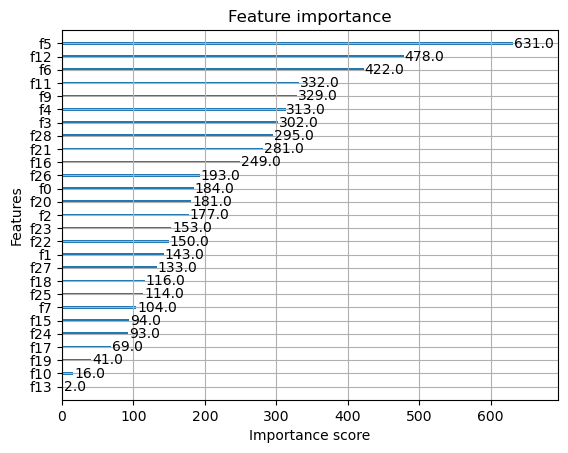

In [5]:
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from Util import Evaluater

# 評估模型
Evaluater.evaluate_model(xgb_clf, (X_train, X_test, y_train, y_test))

# 特徵重要性
import matplotlib.pyplot as plt
xgb_clf.feature_importances_
xgb_clf.get_booster().get_score(importance_type='weight')
xgboost.plot_importance(xgb_clf)
plt.show()

output result

In [6]:
from datetime import datetime

df_test = df_preprocessing[df_preprocessing['acct'].isin(df_test['acct'])].drop(columns=['is_esun']).copy()
y_test_pred = xgb_clf.predict(df_test.drop(columns=['acct']))

df_pred = pd.DataFrame({
    'acct': df_test['acct'],
    'label': y_test_pred
})

df_out = df_test[['acct']].merge(df_pred, on='acct', how='left')
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"xgboost_{current_time}.csv"

df_out.to_csv(os.path.join(outputPath, output_file), index=False)
print(f"(Finish) Output saved to {os.path.join(outputPath, output_file)}")

KeyError: 'acct'